In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from torch.optim import Adam

import torch
from torch import tensor, sigmoid
from pyro.distributions import constraints
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


class Dozen(Dataset):
    def __init__(self, n_samples, hole, noise=None, factor=None):
        super().__init__()
        self.data = self.make_dataset(n_samples, hole, noise, factor)

    def make_dataset(self, n_samples, hole, noise=None, factor=None):
        output = hole.model()
        if not noise:
            noise = output[0][1].item()
        if not factor:
            factor = output[1][1].item()
        self.noise_scalar = noise
        self.factor_scalar = factor
        X, y = datasets.make_circles(n_samples=n_samples, noise=noise, factor=factor)
        dataset = {'noise': (torch.ones([n_samples]).view(-1, 1)*noise).float(), 
                   'factor': (torch.ones([n_samples]).view(-1, 1)*factor).float(),
                   'label': torch.tensor(y).view(-1, 1).float(),
                   'x1': torch.tensor(X[:, 0]).view(-1, 1).float(),
                   'x2': torch.tensor(X[:, 1]).view(-1, 1).float()}
        return dataset

    def __getitem__(self, idx):
        return {name: val[idx] for name, val in self.data.items()}

    def __len__(self):
        return len(self.data.values())


def plot(x1, x2, y):
    X = StandardScaler().fit_transform(np.concatenate([x1, x2], axis=-1))

    plt.title(r'Samples from $p(x_1,x_2)$')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.scatter(X[:,0], X[:,1], alpha=0.5, color=['red' if y_ == 1 else 'green' for y_ in y])
    plt.show()

    plt.subplot(1, 2, 1)
    sns.distplot(X[:,0], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    plt.title(r'$p(x_1)$')
    plt.subplot(1, 2, 2)
    sns.distplot(X[:,1], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    plt.title(r'$p(x_2)$')
    plt.show()

def compare(model, dataset, n=1000):
    x1, x2, y, factor, noise = sample_trained(model.plate_model, n)
    X1, X2, Y, = dataset.data['x1'], dataset.data['x2'], dataset.data['label']

    #plot(x1, x2, y)
    plt.title(r'Joint Distribution')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.scatter(X1, X2, label='data', alpha=0.5, color=['red' if y_ == 1 else 'green' for y_ in Y])
    plt.scatter(x1, x2, label='flow', alpha=0.5, color=['firebrick' if y_ == 1 else 'blue' for y_ in y])
    plt.legend()
    plt.show()

    plt.subplot(1, 2, 1)
    sns.distplot(X1, hist=False, kde=True, 
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='data')
    sns.distplot(x1, hist=False, kde=True, 
                 bins=None, color='firebrick',
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='flow')
    plt.title(r'$p(x_1)$')
    plt.subplot(1, 2, 2)
    sns.distplot(X1, hist=False, kde=True, 
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='data')
    sns.distplot(x1, hist=False, kde=True, 
                 bins=None, color='firebrick',
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='flow')
    plt.title(r'$p(x_2)$')
    plt.show()

def factor_mechanism(noise, N_factor):
    return sigmoid(N_factor + noise)

def sample_trained(plate_model, n=1000):
    handler = poutine.trace(plate_model)
    trace = handler.get_trace(n)
    nodes = ['x1', 'x2', 'label', 'factor', 'noise']
    x1, x2, y, factor, noise = [trace.nodes[node]['value'].detach().numpy() for node in nodes]
    return x1, x2, y, factor, noise



In [8]:
class Donut(PyroModule):
    def __init__(self):
        super().__init__()
        self.noise_alpha = pyro.param('noise_alpha', tensor(1.), constraint=constraints.positive)
        self.noise_beta = pyro.param('noise_beta', tensor(1.), constraint=constraints.positive)
        self.factor_loc = pyro.param('factor_loc', tensor(0.))
        self.factor_scale = pyro.param('factor_scale', tensor(1.), constraint=constraints.positive)
        self.label_prob = pyro.param('label_prob', tensor(0.5), constraint=constraints.positive)
        self._build_flow()

    def _build_flow(self):
        self.x1_transform = T.conditional_spline(1, context_dim=3)
        self.x2_transform = T.conditional_spline(1, context_dim=4)

    def img_model(self):
        # generate noise value
        N_noise = pyro.sample('noise', dist.Beta(self.noise_alpha, self.noise_beta)) #.to_event(1))
        #noise = pyro.sample('noise', dist.Delta(0.2 * N_noise)) #.to_event(1))

        # generate factor value
        N_factor = pyro.sample('factor', dist.Normal(self.factor_loc, self.factor_scale)) #.to_event(1))
        #factor = pyro.sample('factor', dist.Delta(factor_mechanism(noise, N_factor))) #.to_event(1))

        # generate independent label value
        N_label = pyro.sample('label', dist.Bernoulli(self.label_prob)) #.to_event(1))
        #label = pyro.sample('label', dist.Delta(N_label)) #.to_event(1))
        #label.requires_grad = True

        #return (N_noise, 0.2 * N_noise), (N_factor, factor_mechanism(.2 * N_noise, N_factor)), (N_label, N_label)
        return  0.2 * N_noise,  factor_mechanism(.2 * N_noise, N_factor), N_label

#     def img_model(self):
#         # generate noise value
#         N_noise = pyro.sample('N_noise', dist.Beta(self.noise_alpha, self.noise_beta)) #.to_event(1))
#         noise = pyro.sample('noise', dist.Normal((0.2*N_noise), 1e-3)) #.to_event(1))

#         # generate factor value
#         N_factor = pyro.sample('N_factor', dist.Normal(self.factor_loc, self.factor_scale)) #.to_event(1))
#         factor = pyro.sample('factor', dist.Normal(self.factor_mechanism(noise, N_factor), 1e-3)) #.to_event(1))

#         # generate independent label value
#         N_label = pyro.sample('N_label', dist.Bernoulli(self.label_prob)) #.to_event(1))
#         label = pyro.sample('label', dist.Normal(N_label, 1e-3)) #.to_event(1))
#         label.requires_grad = True

#         return (N_noise, noise), (N_factor, factor), (N_label, label)

    def model(self):
        # generate values from the DAG for the image
        #(N_noise, noise), (N_factor, factor), (N_label, label) = self.img_model()
        noise, factor, label = self.img_model()

        # x1 flow
        base_dist = dist.Normal(torch.zeros(1), torch.ones(1)) #.to_event(1))
        x1_context = torch.cat([noise.view(-1, 1), factor.view(-1, 1), label.view(-1, 1)], dim=-1).squeeze()
        x1_context = torch.ones_like(x1_context).detach()
        self.dist_x1_given_scm = dist.ConditionalTransformedDistribution(base_dist, [self.x1_transform])
        x1 = pyro.sample('x1', self.dist_x1_given_scm.condition(x1_context).to_event(1))

        cond_x1_transforms = T.ComposeTransform(self.dist_x1_given_scm.condition(x1_context).transforms)
        N_x1 = cond_x1_transforms.inv(x1)

        # x2 flow
        self.dist_x2_given_scm = dist.ConditionalTransformedDistribution(base_dist, [self.x2_transform]) 
        x2_context = torch.cat([noise.view(-1, 1), factor.view(-1, 1), label.view(-1, 1), x1.view(-1, 1)], dim=-1).squeeze()
        x2_context = torch.ones_like(x2_context).detach()

        x2 = pyro.sample('x2', self.dist_x2_given_scm.condition(x2_context).to_event(1))
        cond_x2_transforms = T.ComposeTransform(self.dist_x2_given_scm.condition(x2_context).transforms)
        N_x2 = cond_x2_transforms.inv(x2)

        return  noise, factor, label, x1, x2

    def plate_model(self, num_particles):
        with pyro.plate('data', num_particles):
            output = self.model()
        return output

    def clear_cache(self):
        try:
            self.dist_x1_given_scm.clear_cache()
            self.dist_x2_given_scm.clear_cache()
        except:
            pass


100%|██████████| 100/100 [00:01<00:00, 83.43it/s]


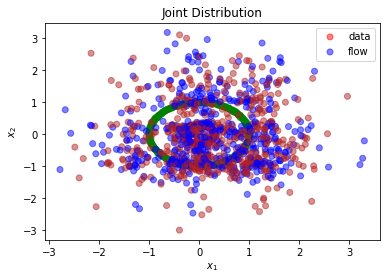

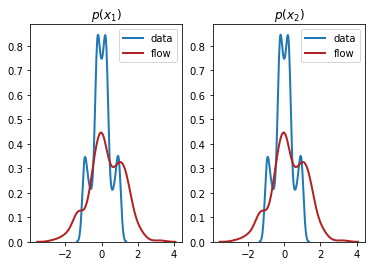

In [10]:
pyro_model = Donut()
dataset =  Dozen(n_samples=1000, hole=pyro_model, noise=0.01, factor=0.3)
batch_size = 16
optimizer = Adam(params=pyro_model.parameters())
loader = DataLoader(dataset, batch_size=batch_size)
num_epochs = 100

pyro.clear_param_store()
losses = list()
for i in tqdm(range(num_epochs)):
    for batch in loader:
        optimizer.zero_grad()
        cond_model = pyro.condition(pyro_model.plate_model, data=batch)
        model_trace = poutine.trace(cond_model).get_trace(batch['x1'].shape[0])
        model_trace.compute_log_prob()
        nodes_keys = ['noise', 'factor', 'label', 'x1', 'x2']
        nodes = dict(model_trace.nodes.items())
        log_probs = {}
        for name in nodes_keys:
            site = nodes[name]
            assert site["type"] == "sample" and site["is_observed"], f'{name, site["type"], site["is_observed"]}'
            log_probs[name] = site["log_prob"].mean()

        loss = -torch.stack(tuple(log_probs.values())).sum()
        losses.append(loss.detach().item())
        loss.backward(retain_graph=True)
        optimizer.step()
        pyro_model.clear_cache()

compare(pyro_model, dataset)

In [ ]:
plot(dozen.data['x1'], dozen.data['x2'], dozen.data['label'])

In [ ]:
sns.distplot(factor)

In [ ]:
plt.plot(coffee.losses)
plt.show()

In [ ]:
# noise, factor = model()
# X, y = datasets.make_circles(n_samples=10, noise=noise.item(), factor=factor.item())
# x1, x2, y = dozen.data['x1'], dozen.data['x2'], dozen.data['label']


In [ ]:
# print(f'noise: {noise.item()}')
# print(f'factor: {factor.item()}')